# Global glacier change in 2100 as a function of global GCM temperature
- 1. vs GMT in 2100 (from Dave)
    - then recompute it (to know if I get the same estimates out)
        - use data from here: https://cluster.klima.uni-bremen.de/~oggm/cmip6/
- 2. vs GMT in 2050 

In [205]:
import os, numpy as np, pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import scipy

## Get temperature changes from CMIP6 data

In [206]:
### FROM DAVE:

fpath = '/home/www/lschuster/rounce_2023_data/0_exploratory_data_analysis/'
#also read in the global temperature change in 2100 relative to 1850-1900 data:
pd_temp_ch_dr = pd.read_csv(fpath+'Global_mean_temp_deviation_2081_2100_rel_1850_1900.csv')
pd_temp_ch_dr['gcm'] = [a.lower() for a in pd_temp_ch_dr['GCM']]
pd_temp_ch_dr['gcm_ssp'] = pd_temp_ch_dr['gcm'] +'_'+pd_temp_ch_dr['Scenario']
pd_temp_ch_dr =pd_temp_ch_dr.set_index('gcm_ssp')
pd_temp_ch_dr = pd_temp_ch_dr[['global_mean_deviation_degC']]

In [207]:
fpath_cmip6 = '/home/www/oggm/cmip6/'
pd_gcm_list = pd.read_csv(fpath_cmip6+'all_gcm_list.csv', index_col='index')

In [208]:
pd_gcm_tas = pd_gcm_list.loc[pd_gcm_list['var'] == 'tas']
pd_gcm_tas['gcm'] = [a.lower() for a in pd_gcm_tas['gcm']]
pd_gcm_tas['gcm_ssp'] = pd_gcm_tas['gcm'] +'_'+pd_gcm_tas['ssp']
pd_gcm_tas = pd_gcm_tas.set_index('gcm_ssp')
# "['ec-earth3_ssp119'] not in CMIP6 but in Dave's data ...
common_gcms = list(set(pd_gcm_tas.index).intersection(pd_temp_ch_dr.index))
pd_gcm_tas = pd_gcm_tas.loc[common_gcms]

/tmp/ipykernel_2424679/1252063683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_gcm_tas['gcm'] = [a.lower() for a in pd_gcm_tas['gcm']]
/tmp/ipykernel_2424679/1252063683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_gcm_tas['gcm_ssp'] = pd_gcm_tas['gcm'] +'_'+pd_gcm_tas['ssp']


In [209]:
load = False
if load:
    period_l = []
    gmc_ssp_l = []
    temp_change_l = []
    temp_change_dr_l = []
    for gcm_ssp in common_gcms:
        ds = xr.open_dataset(pd_gcm_tas.loc[gcm_ssp].path)
        ds = ds.resample(time='1Y').mean()
        # Weight
        weight = np.cos(np.deg2rad(ds.lat.astype(np.float64))).clip(0)
        weight =  ds.tas.isel(time=0) * 0. + weight

        ds['weight'] = (('lat', 'lon'), weight.values / weight.values.sum())
        gmt = (ds.tas* ds.weight).sum(dim=['lon','lat']) - 273.15  # from K to °C
        ref_period_avg = gmt.sel(time=slice(str(1986),str(2005))).mean()

        for exp_time in [2041, 2081]:
            exp_period_avg = gmt.sel(time=slice(str(exp_time), str(exp_time+19))).mean(dim='time')
            gmc_ssp_l.append(gcm_ssp)
            period_l.append(f'{str(exp_time)}-{str(exp_time+19)}')
            temp_change_l.append((exp_period_avg-ref_period_avg + 0.63).values)
            if exp_time == 2081:
                temp_change_dr_l.append(pd_temp_ch_dr.loc[gcm_ssp].values[0])
            else:
                temp_change_dr_l.append(np.NaN)
    pd_temp_ch_manual_extract = pd.DataFrame(index=gmc_ssp_l)
    pd_temp_ch_manual_extract['period'] = period_l
    pd_temp_ch_manual_extract['temp_change'] = temp_change_l
    pd_temp_ch_manual_extract['temp_change_dr'] = temp_change_dr_l
    pd_temp_ch_manual_extract.to_csv('global_temp_ch_gcms.csv')
else:
    pd_temp_ch_manual_extract = pd.read_csv('global_temp_ch_gcms.csv', index_col=[0])
    # Ok, Dave's and my computations are almost equal
    _pd_temp = pd_temp_ch_manual_extract.loc[pd_temp_ch_manual_extract.period=='2081-2100']
    np.testing.assert_allclose(_pd_temp['temp_change'], _pd_temp['temp_change_dr'], rtol=0.001)
    # let's only look at my computations then
    pd_temp_ch = pd_temp_ch_manual_extract[['period', 'temp_change']]

In [210]:
pd_temp_ch

period  temp_change
bcc-csm2-mr_ssp126    2041-2060     1.827834
bcc-csm2-mr_ssp126    2081-2100     1.737504
inm-cm5-0_ssp370      2041-2060     2.049540
inm-cm5-0_ssp370      2081-2100     3.240870
cesm2-waccm_ssp245    2041-2060     2.372428
...                         ...          ...
ec-earth3-veg_ssp126  2081-2100     2.120679
inm-cm4-8_ssp370      2041-2060     1.913100
inm-cm4-8_ssp370      2081-2100     3.219084
mri-esm2-0_ssp585     2041-2060     2.629347
mri-esm2-0_ssp585     2081-2100     4.542293

[102 rows x 2 columns]

## global glacier change in 2100 vs GMT in 2100


In [211]:
# Mass sum for each of the RGI regions ...
ref_yr = 2015
_ds = xr.open_dataset(fpath+'volume_rounce_reg_sum.nc')
_ds = _ds.rename_dims({'time':'year'})
_ds = _ds.set_index(year='time')


_ds = xr.concat([(_ds.glac_mass_annual / 900), ds_glob], dim = 'rgi_region')
ds_glob = _ds.sum(dim='rgi_region', min_count=19)
ds_glob_rel = (ds_glob.sel(year=2101)/ds_glob.sel(year=ref_yr)) * 100
# attention 0 are np.NaN

ds_stack = ds_glob_rel.stack(gcm_ssp = ('gcm', 'ssp'))
ds_stack.coords['gcm_ssp'] = [a[0]+'_'+a[1] for a in ds_stack.gcm_ssp.values]
pd_glob_rel_vol = ds_stack.to_dataframe().dropna()
pd_glob_rel_vol = pd_glob_rel_vol.loc[common_gcms]
pd_temp_ch.loc[pd_glob_rel_vol.index, 'global_rel_vol_2100'] = pd_glob_rel_vol.glac_mass_annual

array(['2041-2060', '2081-2100'], dtype=object)

In [202]:
len(pd_temp_ch_p)

51

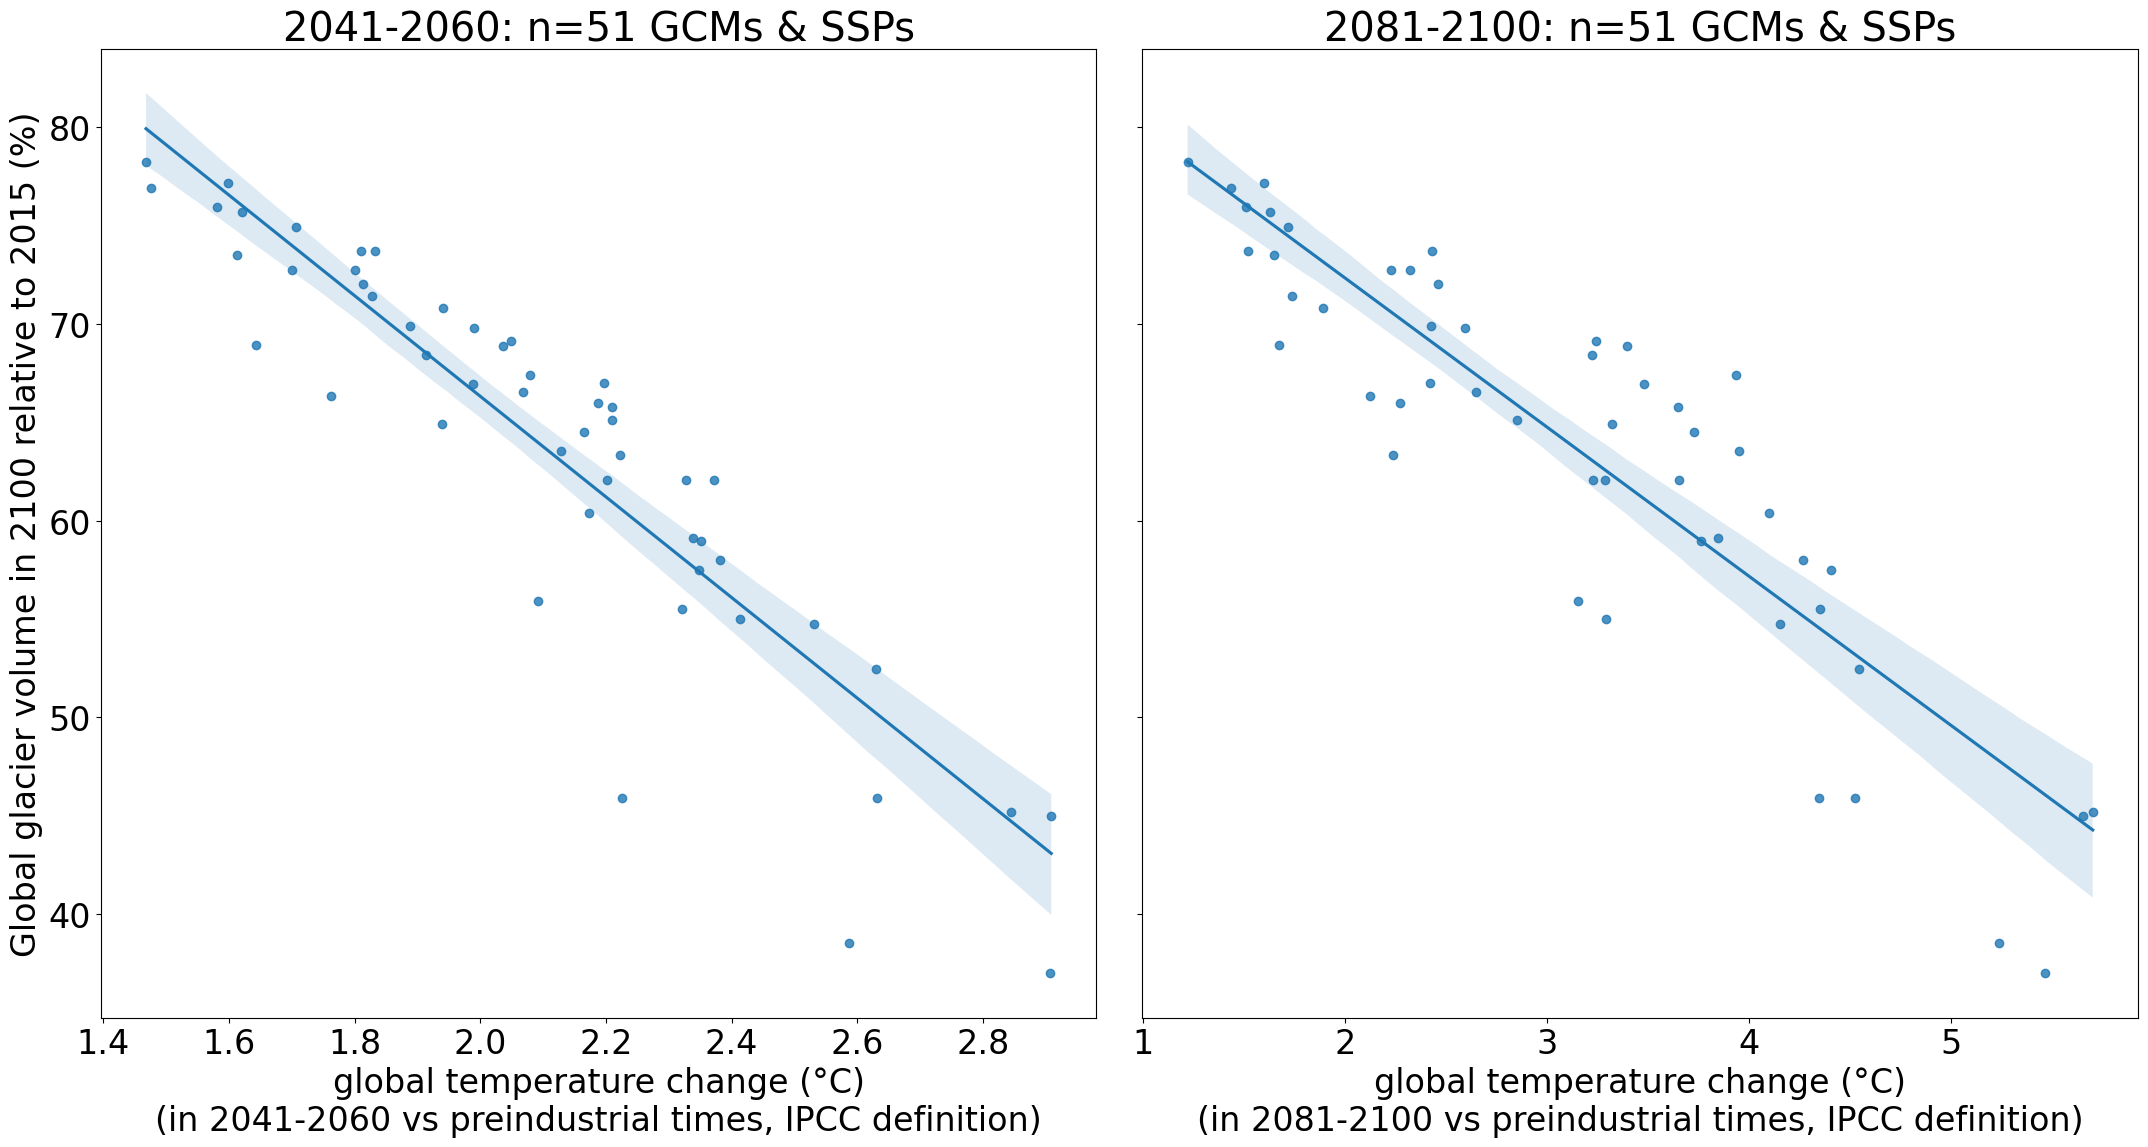

In [204]:
plt.rc('font', size=24)

fig, axs = plt.subplots(1,2,figsize=(22,12), sharey=True) #, sharex=True)
for j,period in enumerate(pd_temp_ch.period.unique()):
    pd_temp_ch_p = pd_temp_ch.loc[pd_temp_ch.period==period]
    n=len(pd_temp_ch_p)
    ax = axs[j]
    sns.regplot(x='temp_change', y='global_rel_vol_2100',data=pd_temp_ch_p, ax = ax)
    #plt.plot(pd_temp_ch_p['temp_change'], pd_temp_ch_p['global_rel_vol_2100'], 'o')
    if j==0:
        ax.set_ylabel('Global glacier volume in 2100 relative to 2015 (%)')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('global temperature change (°C)\n'+f'(in {period} vs preindustrial times, IPCC definition)')
    ax.set_title(period+f': n={n} GCMs & SSPs')
plt.tight_layout()
plt.savefig('glob_glacier_change_vs_glob_temp_ch.pdf')

## regional glacier change

In [214]:
rgi_region = '11'

In [233]:
# Mass sum for each of the RGI regions ...
ref_yr = 2015
_ds = xr.open_dataset(fpath+'volume_rounce_reg_sum.nc')
_ds = _ds.rename_dims({'time':'year'})
_ds = _ds.set_index(year='time')


_ds = xr.concat([(_ds.glac_mass_annual / 900), ds_glob], dim = 'rgi_region')
ds_reg = _ds.sel(rgi_region=rgi_region) #, min_count=19)


############################# rel 2101
ds_reg_rel = (ds_reg.sel(year=2101)/ds_reg.sel(year=ref_yr)) * 100
# attention 0 are np.NaN

ds_stack = ds_reg_rel.stack(gcm_ssp = ('gcm', 'ssp'))
ds_stack.coords['gcm_ssp'] = [a[0]+'_'+a[1] for a in ds_stack.gcm_ssp.values]
pd_reg_rel_vol = ds_stack.to_dataframe().dropna()
pd_reg_rel_vol = pd_reg_rel_vol.loc[common_gcms]

pd_temp_ch.loc[pd_reg_rel_vol.index, f'rgi{rgi_region}_rel_vol_2100'] = pd_reg_rel_vol.glac_mass_annual


#################################### rel 2051
ds_reg_rel_2050 = (ds_reg.sel(year=2051)/ds_reg.sel(year=ref_yr)) * 100
# attention 0 are np.NaN

ds_stack_2050 = ds_reg_rel_2050.stack(gcm_ssp = ('gcm', 'ssp'))
ds_stack_2050.coords['gcm_ssp'] = [a[0]+'_'+a[1] for a in ds_stack_2050.gcm_ssp.values]
pd_reg_rel_vol_2050 = ds_stack_2050.to_dataframe().dropna()
pd_reg_rel_vol_2050 = pd_reg_rel_vol_2050.loc[common_gcms]

pd_temp_ch.loc[pd_reg_rel_vol.index, f'rgi{rgi_region}_rel_vol_2050'] = pd_reg_rel_vol_2050.glac_mass_annual

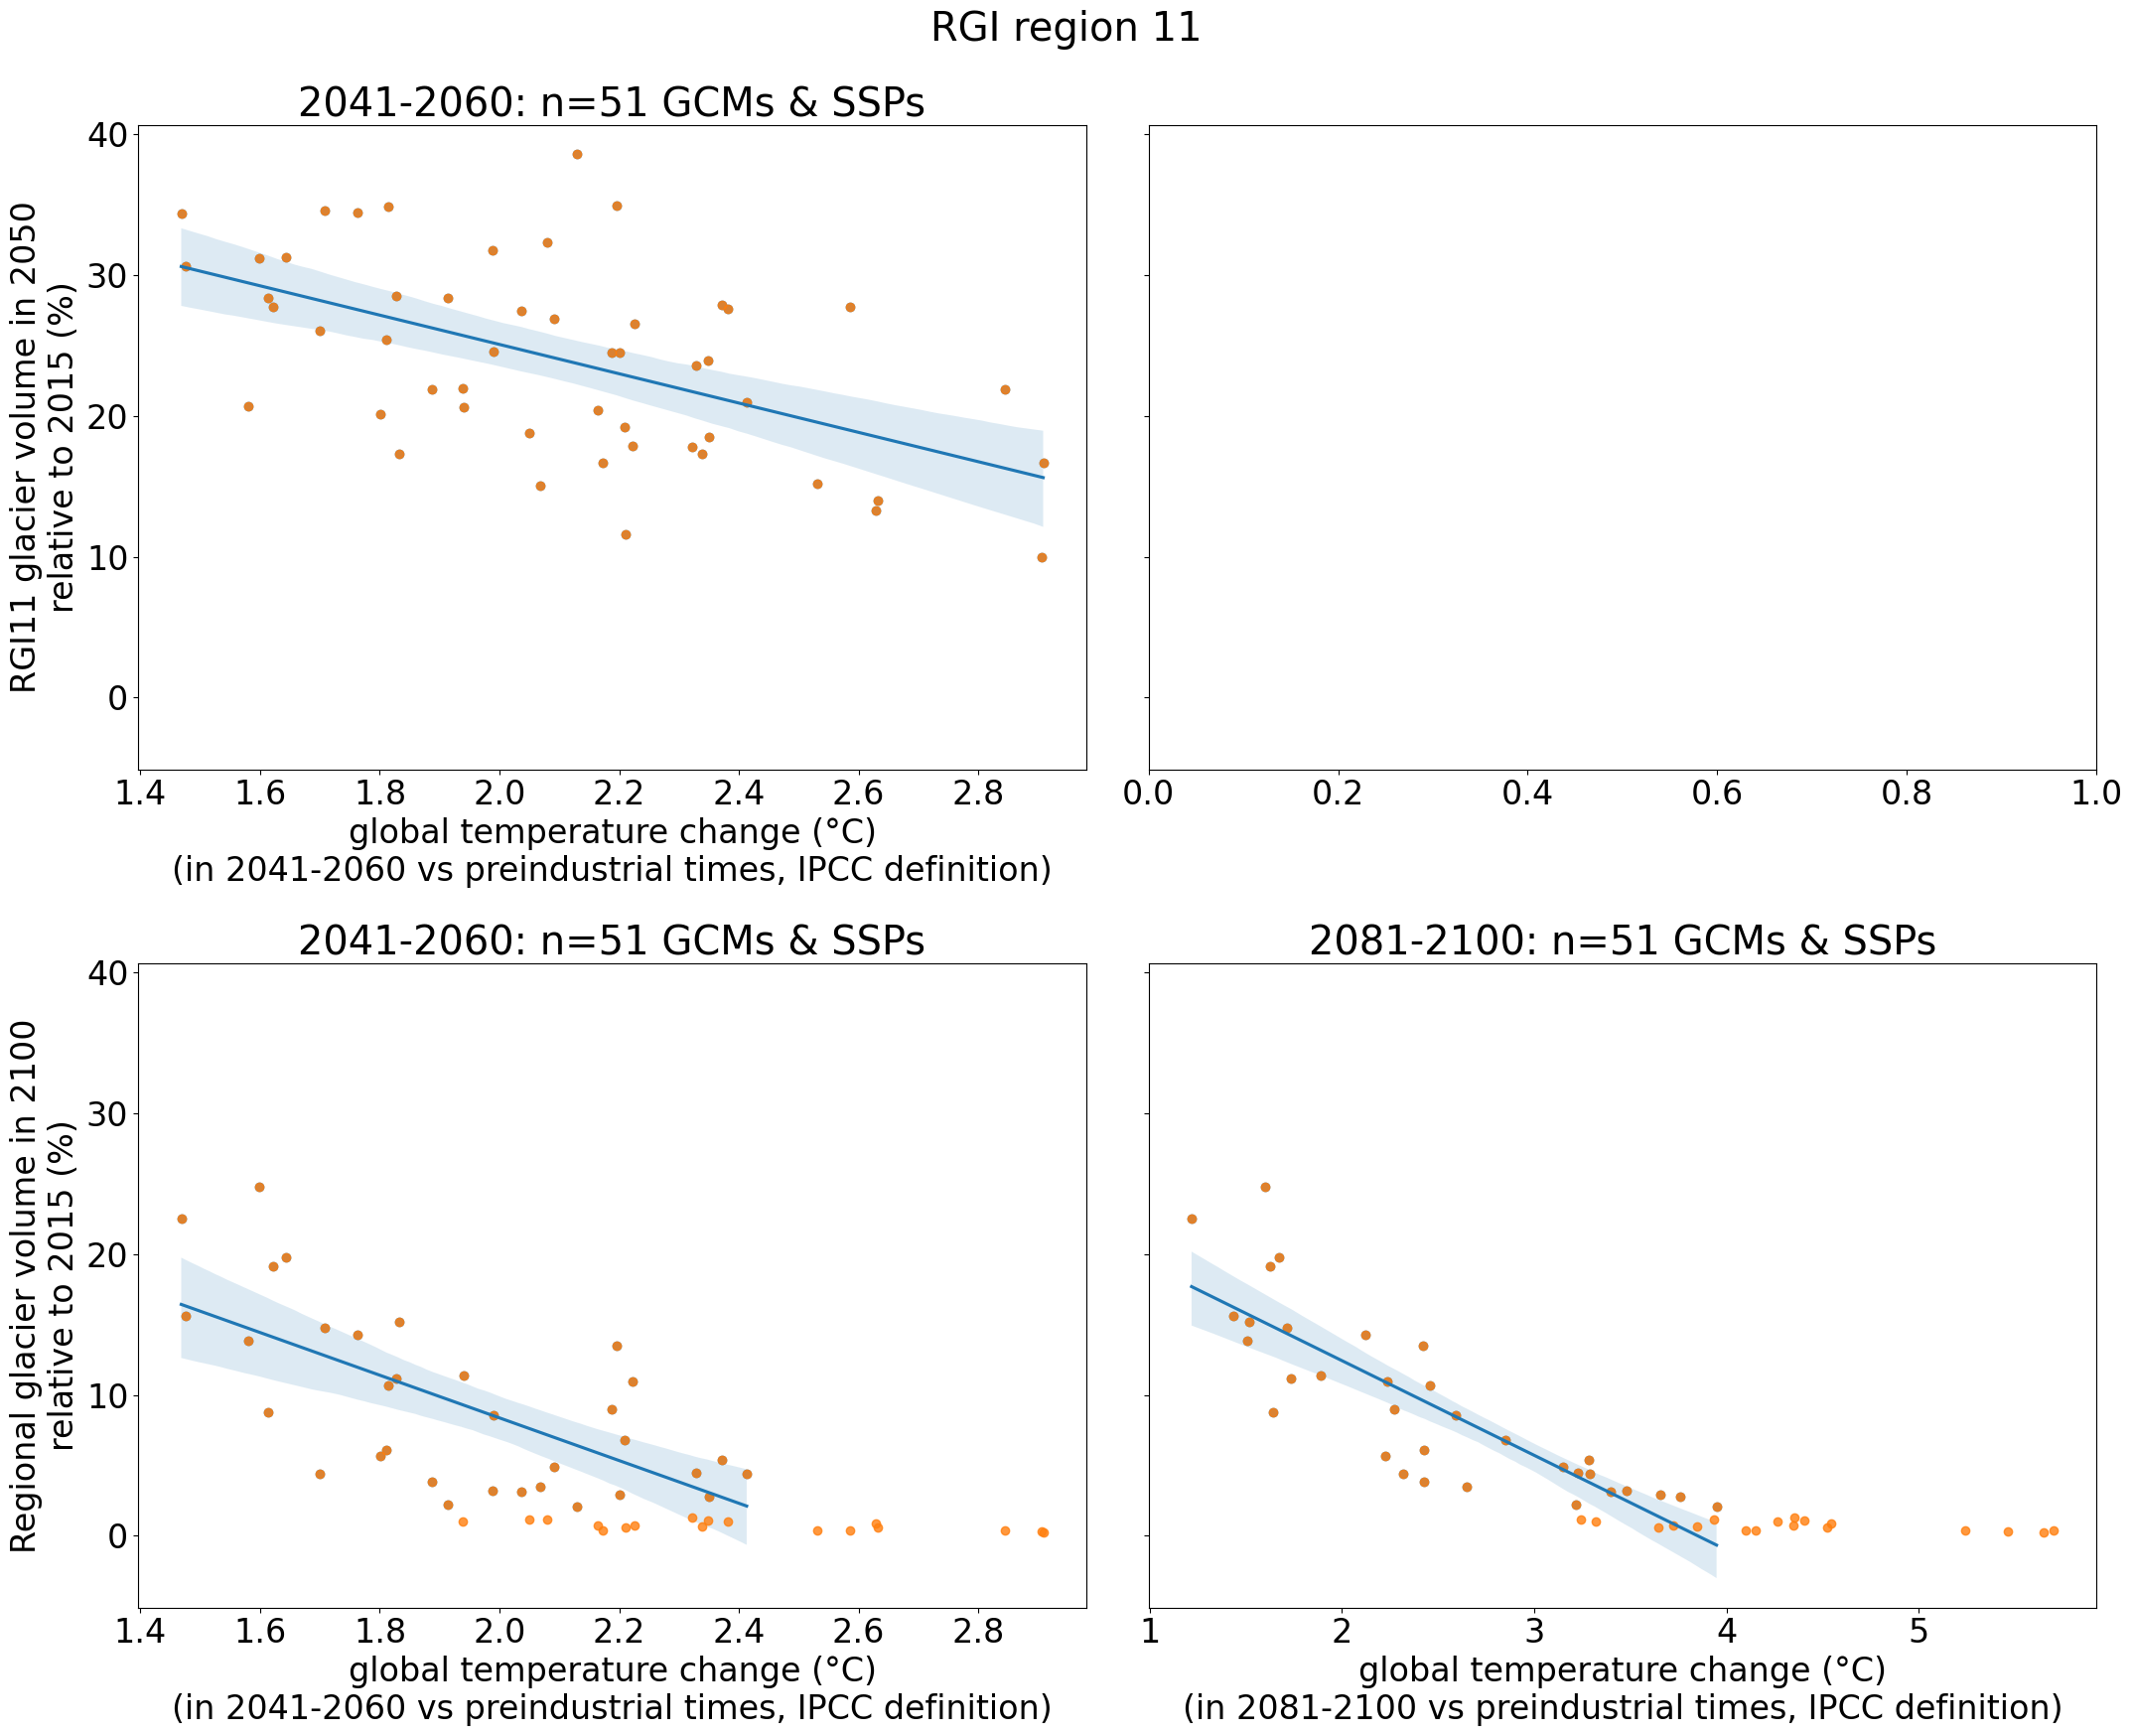

In [244]:
plt.rc('font', size=24)

fig, axs = plt.subplots(2,2,figsize=(22,18), sharey=True) #, sharex=True)

period = pd_temp_ch.period.unique()[0]
pd_temp_ch_p = pd_temp_ch.loc[pd_temp_ch.period==period]
pd_temp_ch_p_exist = pd_temp_ch_p.loc[pd_temp_ch_p[f'rgi{rgi_region}_rel_vol_2050']>=1]
n=len(pd_temp_ch_p)
ax = axs[0][0]
sns.regplot(x='temp_change', y=f'rgi{rgi_region}_rel_vol_2050',data=pd_temp_ch_p_exist, ax = ax)
sns.regplot(x='temp_change', y=f'rgi{rgi_region}_rel_vol_2050',data=pd_temp_ch_p, ax = ax, fit_reg=False)

#plt.plot(pd_temp_ch_p['temp_change'], pd_temp_ch_p['global_rel_vol_2100'], 'o')
ax.set_ylabel(f'RGI{rgi_region} glacier volume in 2050\nrelative to 2015 (%)')
ax.set_xlabel('global temperature change (°C)\n'+f'(in {period} vs preindustrial times, IPCC definition)')
ax.set_title(period+f': n={n} GCMs & SSPs')

for j,period in enumerate(pd_temp_ch.period.unique()):

    pd_temp_ch_p = pd_temp_ch.loc[pd_temp_ch.period==period]
    pd_temp_ch_p_exist = pd_temp_ch_p.loc[pd_temp_ch_p[f'rgi{rgi_region}_rel_vol_2100']>=2]

    n=len(pd_temp_ch_p)
    ax = axs[1][j]
    sns.regplot(x='temp_change', y=f'rgi{rgi_region}_rel_vol_2100',data=pd_temp_ch_p_exist, ax = ax)
    sns.regplot(x='temp_change', y=f'rgi{rgi_region}_rel_vol_2100',data=pd_temp_ch_p, ax = ax, fit_reg=False)

    #plt.plot(pd_temp_ch_p['temp_change'], pd_temp_ch_p['global_rel_vol_2100'], 'o')
    if j==0:
        ax.set_ylabel('Regional glacier volume in 2100\nrelative to 2015 (%)')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('global temperature change (°C)\n'+f'(in {period} vs preindustrial times, IPCC definition)')
    ax.set_title(period+f': n={n} GCMs & SSPs')
plt.suptitle(f'RGI region {rgi_region}')
plt.tight_layout()
plt.savefig(f'rgi{rgi_region}_glacier_change_vs_glob_temp_ch.pdf')